Inicializando o Dashboard...
Dados carregados: 3763 registros.
1164 registros foram ignorados.
Anos processados: ['2021', '2022', '2023']

--- Gerando Dashboard Estático Unificado ---


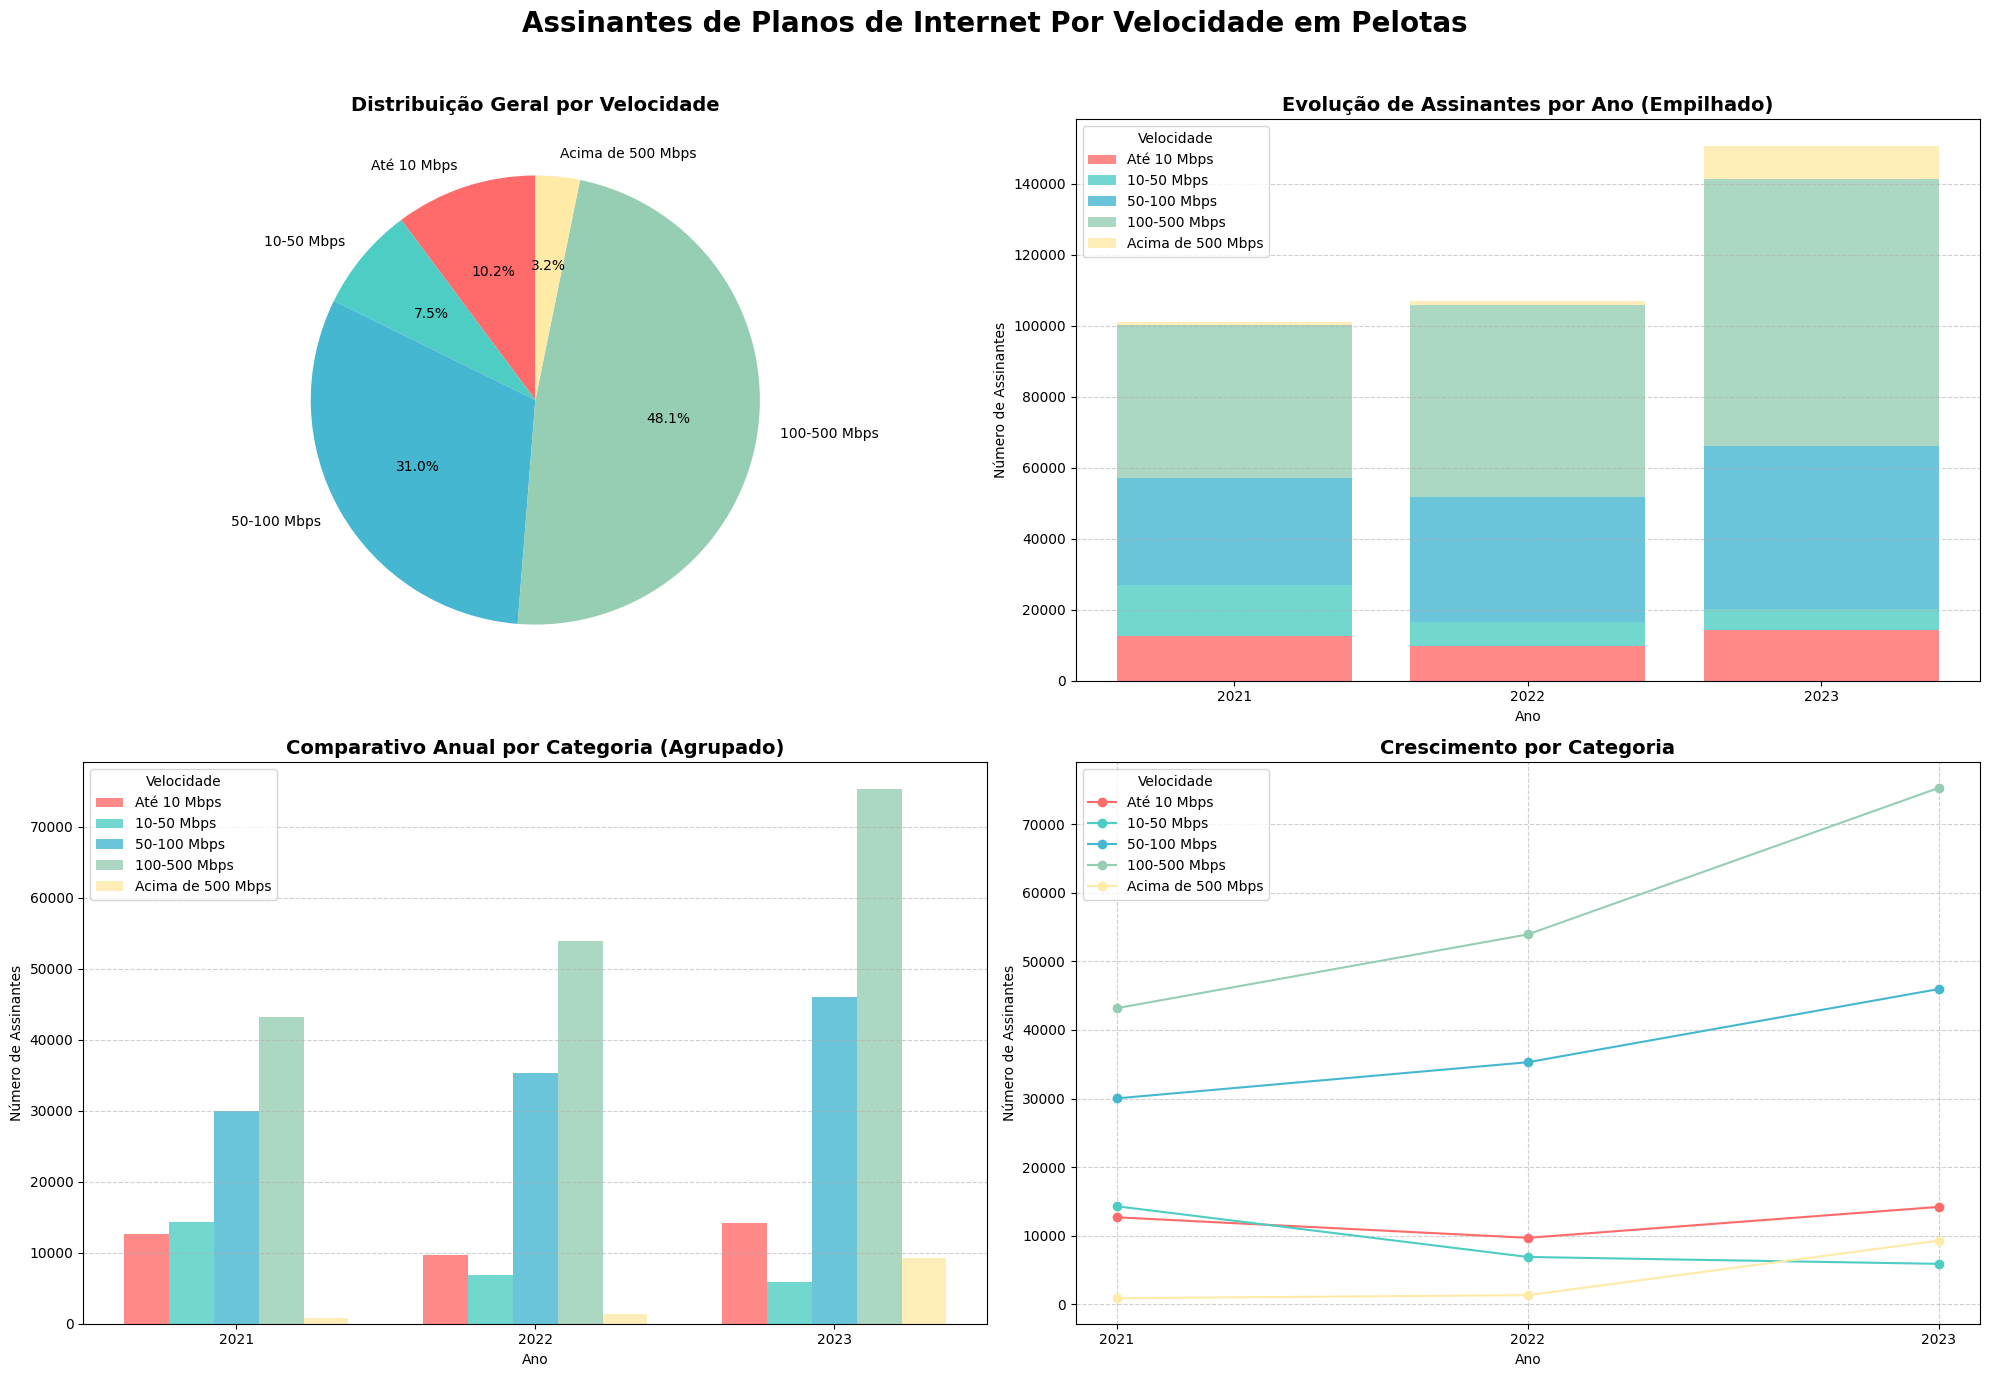


--- Gerando Dashboard Interativo ---


In [ ]:
"""Dashboard de análise de assinantes por velocidade usando dados do Firestore."""

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import firebase_admin
from firebase_admin import credentials, firestore
import plotly.graph_objects as go


def inicializar_firebase():
    """Inicializa a conexão com o Firebase Firestore."""
    if not getattr(firebase_admin, "apps", []):
        caminho_credencial = (
            r'C:\Users\alexa\OneDrive\Documentos'
            r'\tsi-tbd-ale-firebase-adminsdk-fbsvc-9caca5672f.json'
        )
        cred = credentials.Certificate(
            caminho_credencial
        )
        firebase_admin.initialize_app(cred)
    return firestore.client()


def buscar_dados(db):
    """Busca os dados da coleção 'Provedores' no Firestore."""
    try:
        docs = (
            db.collection('Provedores')
            .order_by('mensuracao', direction=firestore.Query.DESCENDING)
            .stream()
        )
        dados = [doc.to_dict() for doc in docs]
        if not dados:
            print("Nenhum dado encontrado na coleção.")
            return pd.DataFrame()
        return pd.DataFrame(dados)
    except (firebase_admin.exceptions.FirebaseError, ValueError) as e:
        print(f"Erro ao buscar dados do Firebase: {e}")
        return pd.DataFrame()


def processar_dados_por_ano(df):
    """Agrupa e processa os dados por ano e por categoria de velocidade."""
    dados_por_ano = defaultdict(lambda: defaultdict(int))
    registros_invalidos = 0

    categorias_velocidade = {
        'Até 10 Mbps': (0, 10),
        '10-50 Mbps': (10, 50),
        '50-100 Mbps': (50, 100),
        '100-500 Mbps': (100, 500),
        'Acima de 500 Mbps': (500, float('inf'))
    }

    for _, linha in df.iterrows():
        try:
            ano = str(linha.get('mensuracao'))[:4]
            velocidade = float(linha.get('velocidade'))
            qt = int(linha.get('qt'))

            if not all([
                ano,
                isinstance(velocidade, float),
                isinstance(qt, int)
            ]):
                raise TypeError(
                    "Dados ausentes ou em formato incorreto."
                )

            if velocidade <= categorias_velocidade['Até 10 Mbps'][1]:
                dados_por_ano[ano]['Até 10 Mbps'] += qt
            elif velocidade < categorias_velocidade['10-50 Mbps'][1]:
                dados_por_ano[ano]['10-50 Mbps'] += qt
            elif velocidade <= categorias_velocidade['50-100 Mbps'][1]:
                dados_por_ano[ano]['50-100 Mbps'] += qt
            elif velocidade <= categorias_velocidade['100-500 Mbps'][1]:
                dados_por_ano[ano]['100-500 Mbps'] += qt
            elif velocidade > categorias_velocidade['Acima de 500 Mbps'][0]:
                dados_por_ano[ano]['Acima de 500 Mbps'] += qt
            else:
                registros_invalidos += 1
                continue


        except (ValueError, TypeError, AttributeError):
            registros_invalidos += 1
            continue

    if registros_invalidos > 0:
        print(
            f"{registros_invalidos} registros foram ignorados."
        )

    anos_processados = sorted(dados_por_ano.keys())
    print(f"Anos processados: {anos_processados}")

    return dict(dados_por_ano), anos_processados


def criar_dashboard_unificado_matplotlib(
    dados_por_ano, anos_disponiveis
):
    """Cria um dashboard estático 2x2 com os principais gráficos usando Matplotlib."""
    if not anos_disponiveis:
        print(
            "Não há dados válidos para gerar o dashboard Matplotlib."
        )
        return

    categorias = [
        'Até 10 Mbps',
        '10-50 Mbps',
        '50-100 Mbps',
        '100-500 Mbps',
        'Acima de 500 Mbps'
    ]
    cores = [
        '#FF6B6B',
        '#4ECDC4',
        '#45B7D1',
        '#96CEB4',
        '#FFEAA7'
    ]

    fig, axes = plt.subplots(
        2, 2, figsize=(20, 14)
    )
    fig.suptitle(
        'Assinantes de Planos de Internet '
        'Por Velocidade em Pelotas',
        fontsize=20,
        fontweight='bold'
    )

    ax1 = axes[0, 0]
    totais_categoria = {
        cat: sum(
            dados_por_ano.get(ano, {}).get(cat, 0)
            for ano in anos_disponiveis
        )
        for cat in categorias
    }
    labels_filtrados = [
        label
        for label, size in totais_categoria.items()
        if size > 0
    ]
    sizes_filtrados = [
        size
        for size in totais_categoria.values()
        if size > 0
    ]
    cores_filtradas = [
        cores[i]
        for i, size in enumerate(totais_categoria.values())
        if size > 0
    ]
    if sizes_filtrados:
        ax1.pie(
            sizes_filtrados,
            labels=labels_filtrados,
            colors=cores_filtradas,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 10}
        )
        ax1.set_title(
            'Distribuição Geral por Velocidade',
            fontsize=14,
            fontweight='bold'
        )
    else:
        ax1.text(
            0.5, 0.5, 'Sem dados',
            ha='center', va='center'
        )

    ax2 = axes[0, 1]
    bottom = np.zeros(len(anos_disponiveis))
    for i, categoria in enumerate(categorias):
        valores = [
            dados_por_ano[ano].get(categoria, 0)
            for ano in anos_disponiveis
        ]
        ax2.bar(
            anos_disponiveis,
            valores,
            bottom=bottom,
            label=categoria,
            color=cores[i],
            alpha=0.8
        )
        bottom += np.array(valores)
    ax2.set_title(
        'Evolução de Assinantes por Ano (Empilhado)',
        fontsize=14,
        fontweight='bold'
    )
    ax2.set_ylabel('Número de Assinantes')
    ax2.set_xlabel('Ano')
    ax2.legend(title='Velocidade')
    ax2.grid(
        axis='y',
        linestyle='--',
        alpha=0.6
    )

    ax3 = axes[1, 0]
    n_categorias = len(categorias)
    n_anos = len(anos_disponiveis)
    bar_width = 0.15
    index = np.arange(n_anos)
    for i, categoria in enumerate(categorias):
        valores = [
            dados_por_ano[ano].get(categoria, 0)
            for ano in anos_disponiveis
        ]
        ax3.bar(
            index + i * bar_width,
            valores,
            bar_width,
            label=categoria,
            color=cores[i],
            alpha=0.8
        )
    ax3.set_title(
        'Comparativo Anual por Categoria (Agrupado)',
        fontsize=14,
        fontweight='bold'
    )
    ax3.set_ylabel('Número de Assinantes')
    ax3.set_xlabel('Ano')
    ax3.set_xticks(
        index + bar_width * (n_categorias - 1) / 2
    )
    ax3.set_xticklabels(anos_disponiveis)
    ax3.legend(title='Velocidade')
    ax3.grid(
        axis='y',
        linestyle='--',
        alpha=0.6
    )

    ax4 = axes[1, 1]
    for i, categoria in enumerate(categorias):
        valores = [
            dados_por_ano[ano].get(categoria, 0)
            for ano in anos_disponiveis
        ]
        ax4.plot(
            anos_disponiveis,
            valores,
            marker='o',
            linestyle='-',
            label=categoria,
            color=cores[i]
        )
    ax4.set_title(
        'Crescimento por Categoria',
        fontsize=14,
        fontweight='bold'
    )
    ax4.set_ylabel('Número de Assinantes')
    ax4.set_xlabel('Ano')
    ax4.legend(title='Velocidade')
    ax4.grid(
        True,
        linestyle='--',
        alpha=0.6
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def criar_dashboard_plotly(dados_por_ano, anos_disponiveis):
    """Cria dashboard interativo Plotly."""
    if not anos_disponiveis:
        print(
            "Não há dados válidos para gerar o dashboard Plotly."
        )
        return

    categorias = [
        'Até 10 Mbps',
        '10-50 Mbps',
        '50-100 Mbps',
        '100-500 Mbps',
        'Acima de 500 Mbps'
    ]
    fig = go.Figure()

    for categoria in categorias:
        valores = [
            dados_por_ano[ano].get(categoria, 0)
            for ano in anos_disponiveis
        ]
        fig.add_trace(
            go.Bar(
                name=categoria,
                x=anos_disponiveis,
                y=valores,
                text=[f'{v:,}' for v in valores],
                textposition='auto',
            )
        )

    fig.update_layout(
        title=(
            'Dashboard Interativo - '
            'Assinantes por Velocidade'
        ),
        xaxis_title='Ano',
        yaxis_title='Número de Assinantes',
        barmode='group',
        height=600,
        legend_title_text='Faixa de Velocidade',
        template='plotly_white'
    )

    fig.show()


def main():
    """Função principal para executar o fluxo de análise e visualização."""
    print("Inicializando o Dashboard...")

    db = inicializar_firebase()
    dataframe = buscar_dados(db)

    if not dataframe.empty:
        print(
            f"Dados carregados: {len(dataframe)} registros."
        )
        dados_por_ano, anos_disponiveis = processar_dados_por_ano(
            dataframe
        )

        if anos_disponiveis:
            print(
                "\n--- Gerando Dashboard Estático Unificado ---"
            )
            criar_dashboard_unificado_matplotlib(
                dados_por_ano, anos_disponiveis
            )

            print(
                "\n--- Gerando Dashboard Interativo ---"
            )
            criar_dashboard_plotly(
                dados_por_ano, anos_disponiveis
            )
        else:
            print(
                "Nenhum dado válido encontrado após o processamento."
            )
    else:
        print(
            "Falha ao carregar dados. Encerrando o script."
        )


if __name__ == "__main__":
    main()